In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score,average_precision_score,plot_precision_recall_curve

In [ ]:
tf.keras.backend.set_floatx('float64')
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.4.0
Eager mode:  True
Hub version:  0.10.0
GPU is available


In [ ]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFOW3ZI/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFOW3ZI/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFOW3ZI/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
#BUILDING A NEURAL NET
#REQUIRES 3 TASKS:
#1: HOW TO REPRESENT THE INPUT (HERE TEXT)
#2: HOW MANY LAYERS?
#3: HOW MANY HIDDEN UNITS FOR EACH LAYER?

In [ ]:
pre_model_1 = "https://tfhub.dev/google/nnlm-en-dim50/2"
pre_model_2 = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2" #same as model_1 but with punctuations for removal
pre_model_3 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2" #larger model of 128 dimensions
hub_layer_1 = hub.KerasLayer(pre_model_1, input_shape=[], dtype=tf.string, trainable=True)
#hub_layer(train_examples[:3])
hub_layer_2 = hub.KerasLayer(pre_model_2, input_shape=[], dtype=tf.string, trainable=True)

hub_layer_3 = hub.KerasLayer(pre_model_3, input_shape=[], dtype=tf.string, trainable=True)


In [ ]:
features_tr = hub_layer_1(train_examples)
features_ts = hub_layer_1(test_examples)


In [ ]:
lsvc = LinearSVC()
# training the model
lsvc.fit(features_tr, train_labels)
lsvc_predictions = lsvc.predict(features_ts)
lsvc_cm = metrics.confusion_matrix(test_labels, lsvc_predictions)

lsvc_score = lsvc.score(features_ts,test_labels)



# getting the score of train and test data
print(lsvc.score(features_tr, train_labels)*100)  
print(lsvc.score(features_ts, test_labels)*100)    

75.144
74.032


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
lr = LogisticRegression()

# training the model
lr.fit(features_tr, train_labels)
lr_predictions = lr.predict(features_ts)
lr_cm = metrics.confusion_matrix(test_labels, lr_predictions)

lr_score = lr.score(features_ts,test_labels)



# getting the score of train and test data
print(lr.score(features_tr, train_labels)*100)  
print(lr.score(features_ts, test_labels)*100)    

75.116
74.028


In [ ]:
# Using Gaussuan Naive Bayes
gnb = GaussianNB()
gnb.fit(features_tr, train_labels)
gnb_predictions = gnb.predict(features_ts)
gnb_cm = metrics.confusion_matrix(test_labels, gnb_predictions)

gnb_score = gnb.score(features_ts,test_labels)



print(gnb.score(features_tr, train_labels)*100)  
print(gnb.score(features_ts, test_labels)*100)    

66.42
65.52


In [ ]:
# Random Forest Classifier
#INTERESTING POINT IF THE TRAINING AND TEST DATASET ARE OF TYPE float32 THIS MODEL DOES NOT WORK
#tf.dtypes.cast function works such that it creates a new tensor variable with new dtype rather than 
#changing the old one
features_tr_rfc=tf.dtypes.cast(features_tr, tf.float64)
features_ts_rfc = tf.dtypes.cast(features_ts, tf.float64)

rfc = RandomForestClassifier(n_estimators = 10, random_state = 0)
rfc.fit(features_tr_rfc, train_labels)

rfc_predictions = rfc.predict(features_ts_rfc)
rfc_cm = metrics.confusion_matrix(test_labels, rfc_predictions)

rfc_score = rfc.score(features_ts_rfc,test_labels)




print(rfc.score(features_tr_rfc, train_labels)*100)  
print(rfc.score(features_ts_rfc, test_labels)*100)    

98.784
66.57600000000001


In [ ]:
model_1 = tf.keras.Sequential()
model_1.add(hub_layer_1)
model_1.add(tf.keras.layers.Dense(16, activation='relu'))
model_1.add(tf.keras.layers.Dense(1))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2 = tf.keras.Sequential()
model_2.add(hub_layer_2)
model_2.add(tf.keras.layers.Dense(16, activation='relu'))
model_2.add(tf.keras.layers.Dense(1))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_2 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_3 = tf.keras.Sequential()
model_3.add(hub_layer_3)
model_3.add(tf.keras.layers.Dense(16, activation='relu'))
model_3.add(tf.keras.layers.Dense(1))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_4 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 124,644,769
Trainable params: 124,644,769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])
model_2.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])
model_3.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [ ]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history_1 = model_1.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,callbacks=[early_stop])

Epoch 1/40
30/30 [==============================] - 4s 81ms/step - loss: 0.6838 - accuracy: 0.5663 - val_loss: 0.6307 - val_accuracy: 0.7146
Epoch 2/40
30/30 [==============================] - 2s 67ms/step - loss: 0.5990 - accuracy: 0.7354 - val_loss: 0.5323 - val_accuracy: 0.7810
Epoch 3/40
30/30 [==============================] - 2s 66ms/step - loss: 0.4775 - accuracy: 0.8270 - val_loss: 0.4287 - val_accuracy: 0.8274
Epoch 4/40
30/30 [==============================] - 2s 66ms/step - loss: 0.3518 - accuracy: 0.8772 - val_loss: 0.3607 - val_accuracy: 0.8504
Epoch 5/40
30/30 [==============================] - 2s 65ms/step - loss: 0.2522 - accuracy: 0.9177 - val_loss: 0.3244 - val_accuracy: 0.8644
Epoch 6/40
30/30 [==============================] - 2s 64ms/step - loss: 0.1847 - accuracy: 0.9414 - val_loss: 0.3094 - val_accuracy: 0.8701
Epoch 7/40
30/30 [==============================] - 2s 66ms/step - loss: 0.1309 - accuracy: 0.9627 - val_loss: 0.3127 - val_accuracy: 0.8736
Epoch 8/40
30

In [ ]:
history_2 = model_2.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,callbacks=[early_stop])

Epoch 1/40
30/30 [==============================] - 3s 87ms/step - loss: 0.6752 - accuracy: 0.5858 - val_loss: 0.5800 - val_accuracy: 0.7591
Epoch 2/40
30/30 [==============================] - 2s 78ms/step - loss: 0.5347 - accuracy: 0.7941 - val_loss: 0.4628 - val_accuracy: 0.8173
Epoch 3/40
30/30 [==============================] - 2s 79ms/step - loss: 0.4029 - accuracy: 0.8537 - val_loss: 0.3717 - val_accuracy: 0.8561
Epoch 4/40
30/30 [==============================] - 2s 79ms/step - loss: 0.2884 - accuracy: 0.9088 - val_loss: 0.3164 - val_accuracy: 0.8743
Epoch 5/40
30/30 [==============================] - 2s 79ms/step - loss: 0.2153 - accuracy: 0.9326 - val_loss: 0.2901 - val_accuracy: 0.8814
Epoch 6/40
30/30 [==============================] - 2s 79ms/step - loss: 0.1574 - accuracy: 0.9531 - val_loss: 0.2750 - val_accuracy: 0.8890
Epoch 7/40
30/30 [==============================] - 2s 79ms/step - loss: 0.1170 - accuracy: 0.9689 - val_loss: 0.2666 - val_accuracy: 0.8915
Epoch 8/40
30

In [ ]:
history_3 = model_3.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,callbacks=[early_stop])

Epoch 1/40
30/30 [==============================] - 4s 117ms/step - loss: 0.6378 - accuracy: 0.6595 - val_loss: 0.4871 - val_accuracy: 0.8014
Epoch 2/40
30/30 [==============================] - 3s 112ms/step - loss: 0.4106 - accuracy: 0.8567 - val_loss: 0.3376 - val_accuracy: 0.8702
Epoch 3/40
30/30 [==============================] - 3s 111ms/step - loss: 0.2473 - accuracy: 0.9216 - val_loss: 0.2793 - val_accuracy: 0.8885
Epoch 4/40
30/30 [==============================] - 3s 112ms/step - loss: 0.1575 - accuracy: 0.9546 - val_loss: 0.2604 - val_accuracy: 0.8962
Epoch 5/40
30/30 [==============================] - 3s 113ms/step - loss: 0.0998 - accuracy: 0.9747 - val_loss: 0.2584 - val_accuracy: 0.8969
Epoch 6/40
30/30 [==============================] - 3s 112ms/step - loss: 0.0588 - accuracy: 0.9902 - val_loss: 0.2657 - val_accuracy: 0.8979
Epoch 7/40
30/30 [==============================] - 3s 112ms/step - loss: 0.0381 - accuracy: 0.9954 - val_loss: 0.2757 - val_accuracy: 0.8949
Epoch 

In [ ]:
l = [model_1,model_2,model_3]
res = []
for x in l:
  res.append(x.evaluate(test_data, test_labels))

782/782 [==============================] - 4s 5ms/step - loss: 0.3649 - accuracy: 0.8694


In [ ]:
history_dict_1 = history_1.history
history_dict_1.keys()

history_dict_2 = history_2.history
history_dict_2.keys()

history_dict_3 = history_3.history
history_dict_3.keys()




dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
#plot accuracy over time
def plot_loss(history_dict,model):
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
  acc = history_dict['accuracy']
  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss for '+model)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

def plot_acc(history_dict,model):
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy for '+model)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

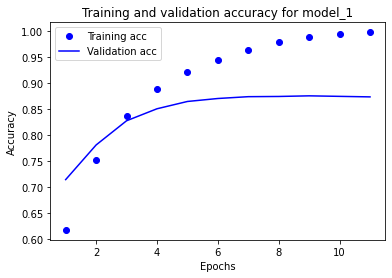

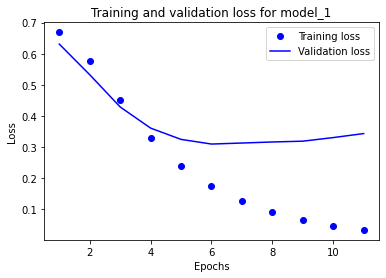

In [ ]:
plot_acc(history_dict_1,'model_1')
plot_loss(history_dict_1,'model_1')

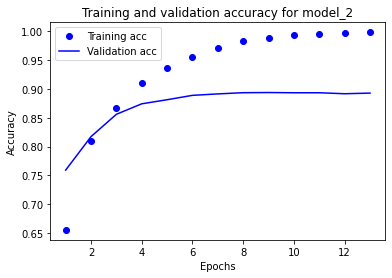

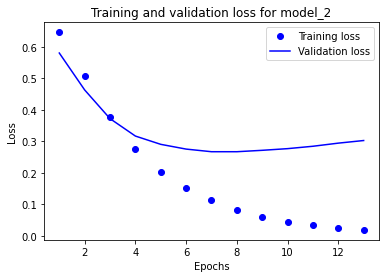

In [ ]:
plot_acc(history_dict_2,'model_2')
plot_loss(history_dict_2,'model_2')

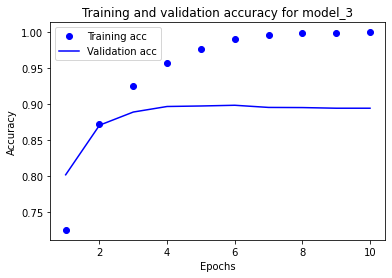

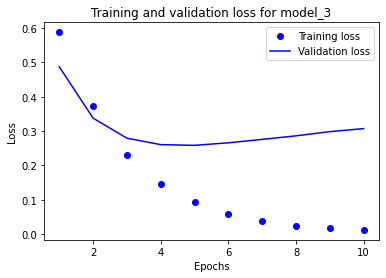

In [ ]:
plot_acc(history_dict_3,'model_3')
plot_loss(history_dict_3,'model_3')

In [ ]:
import seaborn as sns
def confusion_matrix(val,score,model):
    plt.figure(figsize=(9,9))
    sns.heatmap(val, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score for ' + model.upper() +' : {0}'.format(score)
    plt.title(all_sample_title, size = 15)
    plt.show()

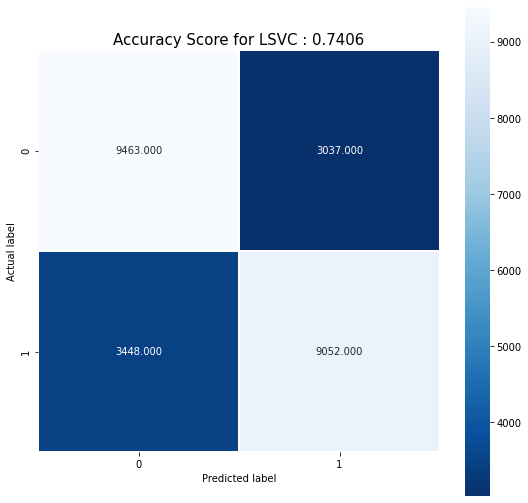

Accuracy, Precision and Recall scores for LinearSVC

accuracy	precision	recall
0.740600	0.748780	0.724160



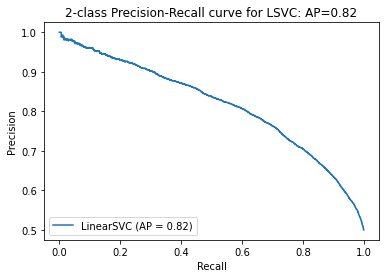

In [ ]:
#LinearSVC
confusion_matrix(lsvc_cm,lsvc_score,'lsvc')
average_precision_lsvc = average_precision_score(test_labels, lsvc.decision_function(features_ts))
disp1 = plot_precision_recall_curve(lsvc, features_ts, test_labels)

disp1.ax_.set_title('2-class Precision-Recall curve for LSVC: '
                   'AP={0:0.2f}'.format(average_precision_lsvc))

lsvc_accuracy, lsvc_precision, lsvc_recall = accuracy_score(test_labels, lsvc_predictions), precision_score(test_labels, lsvc_predictions), recall_score(test_labels, lsvc_predictions)
print("Accuracy, Precision and Recall scores for LinearSVC\n")
print('accuracy', 'precision', 'recall', sep='\t')
print('{:.6f}\t{:.6f}\t{:.6f}\n'.format(lsvc_accuracy, lsvc_precision, lsvc_recall))

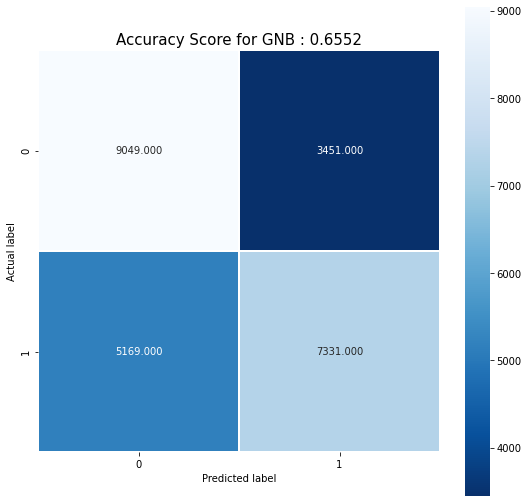

Accuracy, Precision and Recall scores for Gaussian Naive Bayes

accuracy	precision	recall
0.655200	0.679930	0.586480



In [ ]:
#Gaussuan Naive Bayes
confusion_matrix(gnb_cm,gnb_score,'gnb')
gnb_accuracy, gnb_precision, gnb_recall = accuracy_score(test_labels, gnb_predictions), precision_score(test_labels, gnb_predictions), recall_score(test_labels, gnb_predictions)
print("Accuracy, Precision and Recall scores for Gaussian Naive Bayes\n")
print('accuracy', 'precision', 'recall', sep='\t')
print('{:.6f}\t{:.6f}\t{:.6f}\n'.format(gnb_accuracy, gnb_precision, gnb_recall))

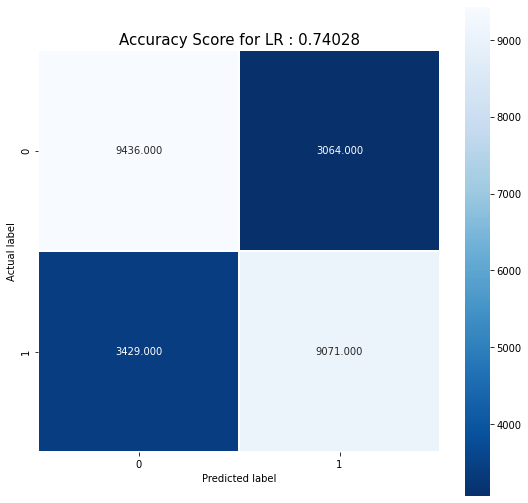

Accuracy, Precision and Recall scores for LinearSVC

accuracy	precision	recall
0.740280	0.747507	0.725680



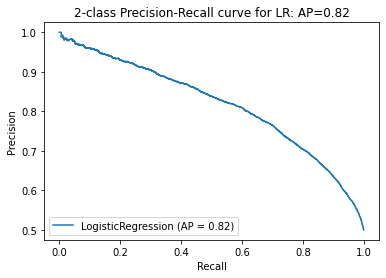

In [ ]:
#Logistic Regression
confusion_matrix(lr_cm,lr_score,'lr')
labels_test = test_labels
labels_train = train_labels
average_precision_lr = average_precision_score(labels_test, lr.decision_function(features_ts))
disp = plot_precision_recall_curve(lr, features_ts, labels_test)
disp.ax_.set_title('2-class Precision-Recall curve for LR: '
                   'AP={0:0.2f}'.format(average_precision_lr))
lr_accuracy, lr_precision, lr_recall = accuracy_score(labels_test, lr_predictions), precision_score(labels_test, lr_predictions), recall_score(labels_test, lr_predictions)
print("Accuracy, Precision and Recall scores for LinearSVC\n")
print('accuracy', 'precision', 'recall', sep='\t')
print('{:.6f}\t{:.6f}\t{:.6f}\n'.format(lr_accuracy, lr_precision, lr_recall))

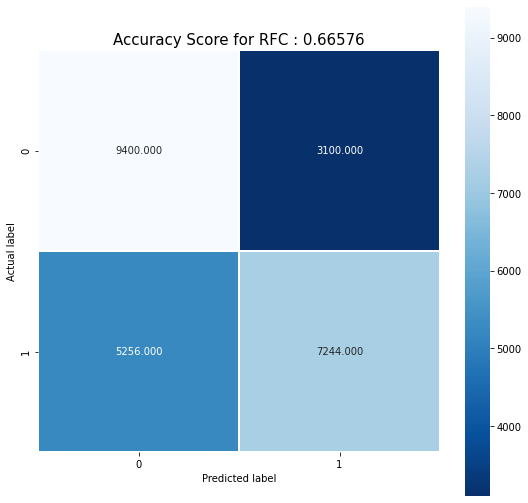

Accuracy, Precision and Recall scores for Random Forest Classifier

accuracy	precision	recall
0.665760	0.700309	0.579520



In [ ]:
#Random Forest Classifier
confusion_matrix(rfc_cm,rfc_score,'rfc')
rfc_accuracy, rfc_precision, rfc_recall = accuracy_score(labels_test, rfc_predictions), precision_score(labels_test, rfc_predictions), recall_score(labels_test, rfc_predictions)


print("Accuracy, Precision and Recall scores for Random Forest Classifier\n")
print('accuracy', 'precision', 'recall', sep='\t')
print('{:.6f}\t{:.6f}\t{:.6f}\n'.format(rfc_accuracy, rfc_precision, rfc_recall))

In [ ]:
features_tr_dt=tf.dtypes.cast(features_tr, tf.float64)
features_ts_dt = tf.dtypes.cast(features_ts, tf.float64)

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(features_tr_dt, labels_train)

Accuracy:  0.61264


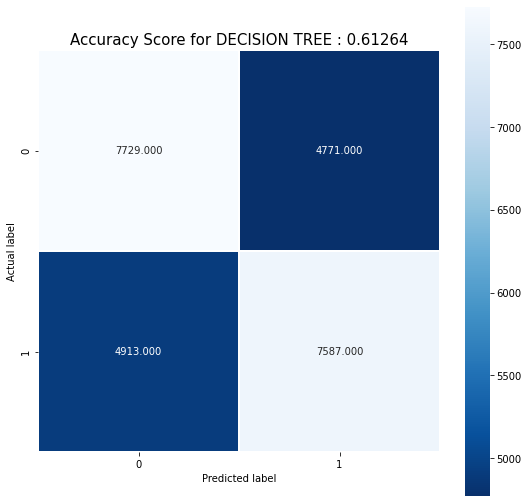

Accuracy, Precision and Recall scores for Decision Tree

accuracy	precision	recall
0.612640	0.613934	0.606960



In [ ]:
dt_predictions = clf.predict(features_ts_dt)

dt_cm = metrics.confusion_matrix(test_labels, dt_predictions)
y_score = clf.score(features_ts_dt, labels_test)
print('Accuracy: ', y_score)

confusion_matrix(dt_cm,y_score,'decision tree')
dt_accuracy, dt_precision, dt_recall = accuracy_score(labels_test, dt_predictions), precision_score(labels_test, dt_predictions), recall_score(labels_test, dt_predictions)


print("Accuracy, Precision and Recall scores for Decision Tree\n")
print('accuracy', 'precision', 'recall', sep='\t')
print('{:.6f}\t{:.6f}\t{:.6f}\n'.format(dt_accuracy, dt_precision, dt_recall))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
features_tr_knn=tf.dtypes.cast(features_tr, tf.float64)
features_ts_knn = tf.dtypes.cast(features_ts, tf.float64)

mod = KNeighborsClassifier(n_neighbors=5)
mod.fit(features_tr_knn,labels_train)

#Predict Output
predicted= mod.predict(features_ts_knn) 


Accuracy:  0.61264


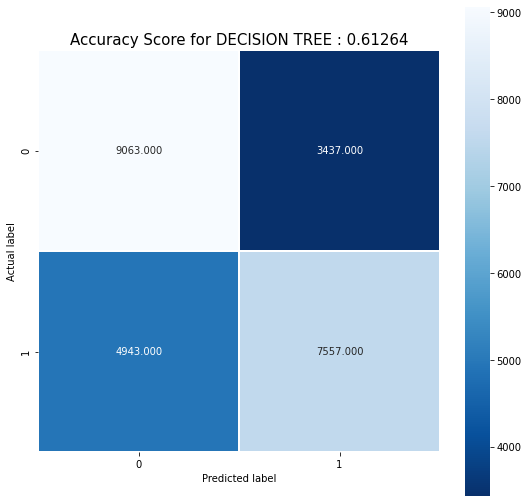

Accuracy, Precision and Recall scores for KNN

accuracy	precision	recall
0.664800	0.687375	0.604560



In [ ]:
knn_cm = metrics.confusion_matrix(test_labels, predicted)
knn_score = clf.score(features_ts_knn, labels_test)
print('Accuracy: ', knn_score)

confusion_matrix(knn_cm,knn_score,'decision tree')
knn_accuracy, knn_precision, knn_recall = accuracy_score(labels_test, predicted), precision_score(labels_test, predicted), recall_score(labels_test, predicted)


print("Accuracy, Precision and Recall scores for KNN\n")
print('accuracy', 'precision', 'recall', sep='\t')
print('{:.6f}\t{:.6f}\t{:.6f}\n'.format(knn_accuracy, knn_precision, knn_recall))